In [2]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

filename = "datasets/original_dataset.xlsx"
df = pd.read_excel(filename, engine='openpyxl')

df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1.341142,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.419549,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667


# Stage 1 modeling

In [3]:
# Separate data into training and validation sets
train_df = df[df['TrainVal'] == 'Train_60']
val_df = df[df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                 'Short_1','Short_2','Short_3','Short_4','Short_5',
                                 'Short_6','Short_7','Short_8','Short_9', 'Short_10'])
y_train = train_df['target']

X_val = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                             'Short_1','Short_2','Short_3','Short_4','Short_5',
                             'Short_6','Short_7','Short_8','Short_9', 'Short_10'])
y_val = val_df['target']

In [4]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}
clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

best_clf = grid_search.best_estimator_

# Predict using the best model
# y_pred = best_clf.predict(X_val_new)



Fitting 3 folds for each of 324 candidates, totalling 972 fits
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}


In [5]:
# Predicting class probabilities
# Each row represents two scores: [probability_of_class_0, probability_of_class_1]
train_scores = best_clf.predict_proba(X_train)[:, 1]
val_scores = best_clf.predict_proba(X_val)[:, 1]
print(X_val.shape)
# If you're interested in probabilities of class 1 (usually the "positive" class)
train_df = train_df.copy()
val_df = val_df.copy()
# Supress warnings
train_df['scores'] = train_scores
val_df['scores'] = val_scores
# Concatenating vertically
all_data_with_scores = pd.concat([train_df, val_df], axis=0)

# If you need to merge this back with original data, you can use merge
# (assuming `UniqueID` is a column that can be used to match rows):
stage_2_df = pd.merge(df, all_data_with_scores[['UniqueID', 'scores']], on='UniqueID', how='left')


stage_2_df

(1831, 10)


,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10,scores
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.414460
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.453624
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.388046
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.373537
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.396929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667,0.380085
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000,0.372056
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667,0.443616
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,1.317842,48.831847,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667,0.434775


# Stage 2 modeling

In [6]:
# Separate data into training and validation sets
train_df = stage_2_df[stage_2_df['TrainVal'] == 'Train_60']
val_df = stage_2_df[stage_2_df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train = train_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_train = train_df['target']

X_val = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val = val_df['target']

In [7]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}
clf = xgb.XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(grid_search.best_params_)

best_clf = grid_search.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}


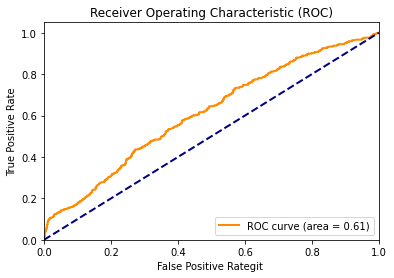

,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,Long_7,Long_8,Long_9,Long_10,...,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10,scores
1,5700.0,8.0,0.0,221.0,12.0,15.0,17.0,NaN,7.0,-357.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.453624
5,NaN,NaN,NaN,88.0,NaN,8.0,52.0,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.388650
6,NaN,NaN,NaN,533.0,NaN,1.0,41.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.371901
10,2300.0,0.0,0.0,113.0,0.0,4.0,23.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.385547
11,3000.0,2.0,0.0,143.0,40.0,1.0,16.0,NaN,1.0,457.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,100.0,0.0,0.0,329.0,84.0,5.0,18.0,6548.0,2.0,0.0,...,0.619423,50.540810,6924.333077,63.977810,14891.68846,8712.87,68.417646,0.481822,0.000000,0.376462
4590,200.0,9.0,3710.0,452.0,12.0,2.0,26.0,10163.0,3.0,NaN,...,1.356323,89.322771,5203.520000,75.401304,52749.77250,40933.79,28.947341,0.090419,5.500000,0.375956
4591,3100.0,1.0,NaN,430.0,NaN,6.0,12.0,30798.0,5.0,NaN,...,0.932940,52.949196,3918.912500,39.789514,56475.94250,46615.11,83.763616,0.077182,4.250000,0.377695
4596,100.0,3.0,6741.0,281.0,198.0,3.0,0.0,101175.0,3.0,202.0,...,0.985568,41.803426,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667,0.443616


In [9]:
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set

y_pred = best_clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/2_stage_modeling_result.jpg')
plt.show()
X_val